In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from scipy import misc
import pandas as pd
import cv2

# part A

In [115]:
img_path = 'wheres_wally_3.jpg'
csv_path = 'colors.csv'

index=["color","color_name","hex","R","G","B"]
csv = pd.read_csv(csv_path, names=index, header=None)

img = cv2.imread(img_path)

clicked = False
xpos = 0
ypos = 0
b=g=r = 0

def getColorName(R,G,B):
    minimum = 10000
    for i in range(len(csv)):
        d = abs(R- int(csv.loc[i,"R"])) + abs(G- int(csv.loc[i,"G"]))+ abs(B- int(csv.loc[i,"B"]))
        if(d<=minimum):
            minimum = d
            cname = csv.loc[i,"color_name"]
    return cname

def draw_function(event, x,y,flags,param):
    if event == cv2.EVENT_LBUTTONDBLCLK:
        global b,g,r,xpos,ypos, clicked
        clicked = True
        xpos = x
        ypos = y
        b,g,r = img[y,x]
        b = int(b)
        g = int(g)
        r = int(r)

cv2.namedWindow('image')
cv2.setMouseCallback('image',draw_function)

while True:
    cv2.imshow("image",img)
    if clicked:
        cv2.rectangle(img,(20,20), (750,60), (b,g,r), -1)
        text = getColorName(r,g,b) + ' R='+ str(r) + ' G='+ str(g) + ' B='+ str(b)
        cv2.putText(img, text,(50,50),2,0.8,(255,255,255),2,cv2.LINE_AA)
        if(r+g+b>=600):
            cv2.putText(img, text,(50,50),2,0.8,(0,0,0),2,cv2.LINE_AA)
        clicked=False
    if cv2.waitKey(20) & 0xFF ==27:
        break

cv2.destroyAllWindows()

# part B

In [56]:
from tqdm import tqdm
img = Image.open("wheres_wally_1.jpg")

width = img.size[0] 
height = img.size[1] 

copy_img = Image.new("RGB", (width, height), (0, 0, 0))

pixel_list = []

for i in tqdm(range(0,width)):
    for j in range(0,height):
        data = img.getpixel((i,j))   
        if (data[0]>=200 and data[0]<=255 and data[1]>=50 and data[1]<=90 and data[2]>=50 and data[2]<=110)  :
            for t in range(-50,50):
                for z in range(-50,50):
                    new_i = i+t
                    new_j = j+z   
                    if new_i >=0 and new_i< width and new_j>=0 and new_j< height:
                        pixel_list.append([new_i,new_j])
                

100%|█████████████████████████████████████████████████████████████████████████████| 1700/1700 [00:06<00:00, 278.51it/s]


In [57]:
for el in pixel_list:
    i_ = el[0]
    j_ = el[1]
    copy_img.putpixel((i_,j_),img.getpixel((i_,j_)))
    
copy_img.save('where_is_wally_mask_1.png')

# part C & D

In [2]:
import cv2 as cv
def downscale_img(img, proportion):
    height, width = img.shape[0],img.shape[1]
    scaled_height = np.int(np.ceil(height*proportion))
    scaled_width = np.int(np.ceil(width*proportion))
    scaled_img = np.zeros((scaled_height, scaled_width, 3), dtype='uint8')
    for x in range(scaled_width):
        for y in range(scaled_height):
            for c in range(3):
                scaled_img[y,x,c] = np.mean(img[2*y:2*y+2,2*x:2*x+2,c]).astype('uint8')
    return scaled_img

def  pixel_diff(channel1,channel2):
    channel1_b = channel1[:,:,0]
    channel1_g = channel1[:,:,1]
    channel1_r = channel1[:,:,2]
    
    channel2_b = channel2[:,:,0]
    channel2_g = channel2[:,:,1]
    channel2_r = channel2[:,:,2]
    
    diff_b = np.abs(channel1_b-channel2_b)
    diff_g = np.abs(channel1_g-channel2_g)
    diff_r = np.abs(channel1_r-channel2_r)
    
    return np.sum(diff_b)+np.sum(diff_g)+np.sum(diff_r)

def search(search_image, template, metric, return_score=False):
    search_height, search_width = search_image.shape[:2]
    template_height, template_width = template.shape[:2]
    target_location = np.arange(2)
    max_score = np.nan
    for x in range(search_width-template_width):
        for y in range(search_height-template_height):
            candidate = search_image[y:y+template_height, x:x+template_width]
            score = metric(candidate, template)
            if np.isnan(max_score) or score>max_score:
                max_score = score
                target_location = (y,x)
    return (target_location, max_score) if return_score else target_location

def point_result(search_image, template, target_location, border_prop):
    sie = search_image.copy()
    template_height, template_width = template.shape[:2]
    yt, xt = target_location
    cv.rectangle(sie, (xt, yt), (xt+template_width, yt+template_height, ), (255,255,255), border_prop)
    return sie

In [70]:
wally1 = cv.imread('wally_1.jpg')
wally1 = cv.cvtColor(wally1, cv.COLOR_RGB2BGR)


In [71]:
wheres_wally_1 = cv.imread('where_is_wally_mask_1.png')
wheres_wally_1 = cv.cvtColor(wheres_wally_1, cv.COLOR_RGB2BGR)

In [72]:
wheres_wally_1_scaled = downscale_img(downscale_img(wheres_wally_1, 0.5), 0.5)
wally1s = downscale_img(downscale_img(wally1, 0.5), 0.5)

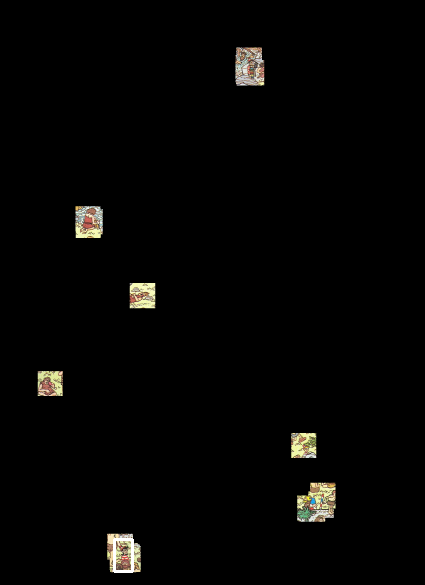

In [73]:
ht, wt = wally1s.shape[:2]
(yt, xt) = search(wheres_wally_1_scaled, wally1s, pixel_diff)
Image.fromarray(point_result(wheres_wally_1_scaled, wally1s, (yt, xt), 2))